In [2]:
import sys
sys.path.append('../../')

from utils.DataLoader import load_data
from utils.Library import *

cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

train_df, test_df = load_data(
    train_path='../../data/train_8000_final.p',
    test_path='../../data/test_2000_final.p',
    cols_to_drop=cols_to_drop
)


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#background: season, policy, self-empl
#diagnosis: pneu, cold
#underlying condition: asthma, smoking, COPD
#symptoms: dyspnea, cough, pain, fever, nasal

BN = BayesianNetwork([
    ('smoking', 'COPD'),
    ('smoking', 'cough'),
    ('smoking', 'dysp'),
    ('asthma', 'dysp'),
    ('asthma', 'pneu'),
    ('asthma', 'cough'),
    ('hay_fever', 'dysp'),
    ('hay_fever', 'nasal'),
    ('COPD', 'pneu'),
    ('COPD', 'dysp'),
    ('COPD', 'cough'),
    ('COPD', 'pain'),
    ('winter', 'pneu'),
    ('winter', 'inf'),
    ('pneu', 'dysp'),
    ('pneu', 'cough'),
    ('pneu', 'pain'),
    ('pneu', 'fever'),
    ('inf', 'cough'),
    ('inf', 'pain'),
    ('pneu', 'fever'),
    ('pneu', 'nasal'),
    ('cough', 'pain')
])

BN2 = BayesianNetwork([
    ('winter', 'pneu'),
    ('winter', 'inf')
])

In [4]:
def BN_model_train_general(BN_model, train_df, test_df, target):
    print(f"🔹 Đang chạy với target: {target}")
    
    # Chuyển đổi nhãn thành 0 và 1
    train_df[target] = train_df[target]
    test_df[target] = test_df[target]

    # Huấn luyện mô hình
    BN_model.fit(train_df, estimator=BayesianEstimator)
    inference = VariableElimination(BN_model)

    # Chuẩn bị dữ liệu test
    test_features = test_df.drop(columns=[target])
    y_true = test_df[target].values

    # Dự đoán trên tập test
    test_features = test_df.drop(columns=[target])
    y_true = test_df[target].values
    y_pred = np.array([
        inference.query(variables=[target], evidence=row.to_dict()).values[1]  
        for _, row in test_features.iterrows()
    ])

    
    return y_true, y_pred


In [7]:
def plot_roc_pr(y_true1, y_pred1, y_true2, y_pred2, target_name="target"):
    # ROC
    fpr1, tpr1, _ = roc_curve(y_true1, y_pred1)
    fpr2, tpr2, _ = roc_curve(y_true2, y_pred2)
    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)

    # PR
    precision1, recall1, _ = precision_recall_curve(y_true1, y_pred1)
    precision2, recall2, _ = precision_recall_curve(y_true2, y_pred2)
    pr_auc1 = auc(recall1, precision1)
    pr_auc2 = auc(recall2, precision2)

    # Vẽ
    plt.figure(figsize=(12, 5))

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr1, tpr1, label=f'BN1 (Season) AUC = {auc1:.2f}')
    plt.plot(fpr2, tpr2, linestyle='--', label=f'BN2 (Season+Symptoms+Clinical) AUC = {auc2:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({target_name})')
    plt.legend()

    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall1, precision1, label=f'BN1 (Season) AUC = {pr_auc1:.2f}')
    plt.plot(recall2, precision2, linestyle='--', label=f'BN2 (Season+Symptoms+Clinical) PR AUC = {pr_auc2:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({target_name})')
    plt.legend()

    plt.tight_layout()
    plt.show()


Seed 0 - Target: pneu
🔹 Đang chạy với target: pneu


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: pneu



Seed 1 - Target: pneu
🔹 Đang chạy với target: pneu


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: pneu



Seed 2 - Target: pneu
🔹 Đang chạy với target: pneu


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: pneu



Seed 3 - Target: pneu
🔹 Đang chạy với target: pneu


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: pneu



Seed 4 - Target: pneu
🔹 Đang chạy với target: pneu


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: pneu


Best score for pneu: 2.5934

Seed 0 - Target: inf
🔹 Đang chạy với target: inf


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: inf



Seed 1 - Target: inf
🔹 Đang chạy với target: inf


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: inf



Seed 2 - Target: inf
🔹 Đang chạy với target: inf


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: inf



Seed 3 - Target: inf
🔹 Đang chạy với target: inf


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: inf



Seed 4 - Target: inf
🔹 Đang chạy với target: inf


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_10120\2350023760.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: inf
Best score for inf: 3.2434


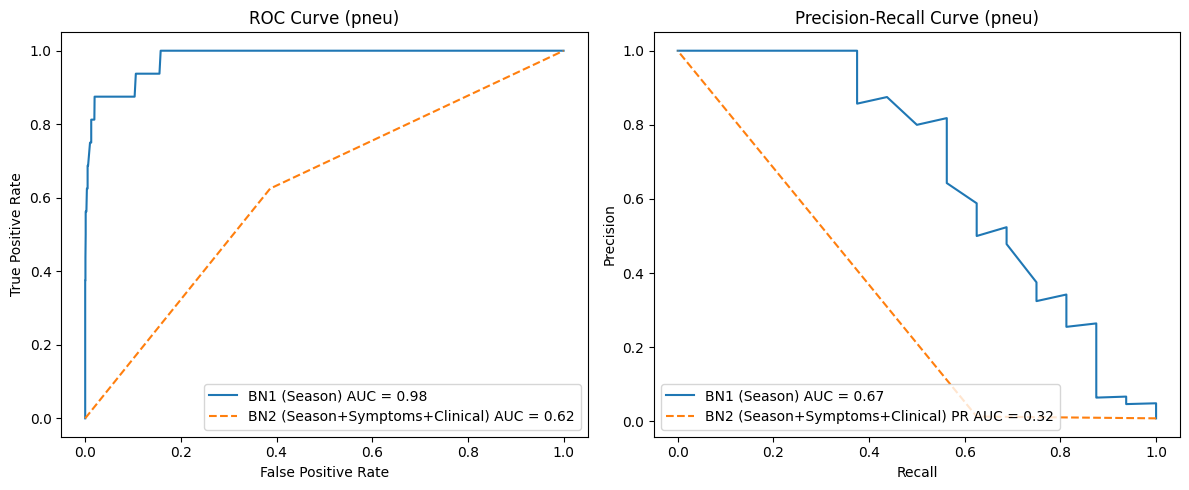

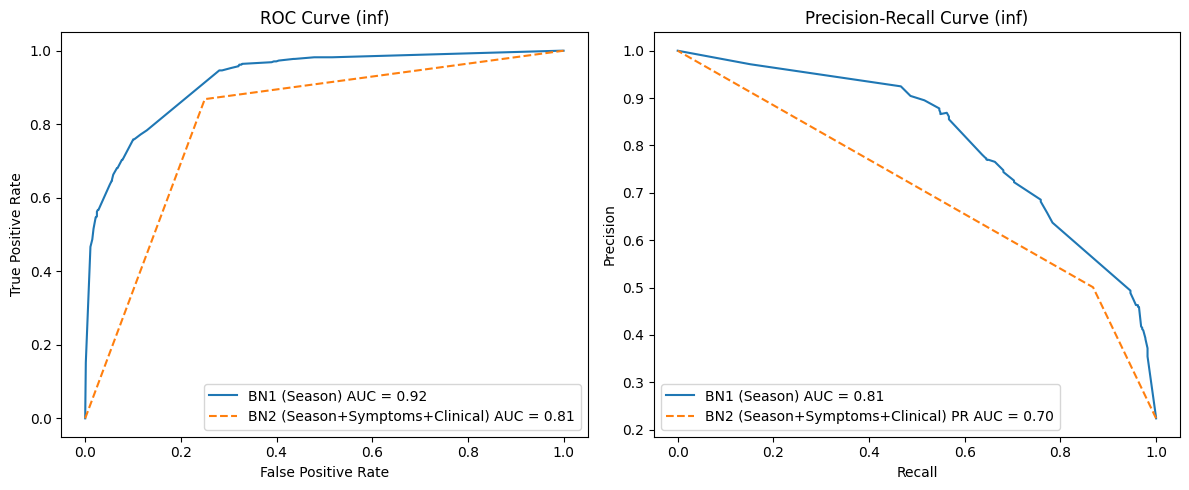

In [8]:
def evaluate_auc(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    return roc_auc, pr_auc

best_results = {}

targets = ["pneu", "inf"]

for target in targets:
    best_score = -1
    best_y_true1, best_y_pred1 = None, None
    best_y_true2, best_y_pred2 = None, None

    for seed in range(5):
        print(f"\nSeed {seed} - Target: {target}")
        np.random.seed(seed)
        random.seed(seed)

        # Model 1: Đầy đủ 12 features
        y_true1, y_pred1 = BN_model_train_general(BN, train_df.iloc[:, :12], test_df.iloc[:, :12], target)
        roc1, pr1 = evaluate_auc(y_true1, y_pred1)

        # Model 2: Chỉ 3 feature ["winter", "pneu", "inf"]
        y_true2, y_pred2 = BN_model_train_general(BN2, train_df[["winter", "pneu", "inf"]], test_df[["winter", "pneu", "inf"]], target)
        roc2, pr2 = evaluate_auc(y_true2, y_pred2)

        # Tổng AUC 2 mô hình
        total_score = roc1 + pr1 + roc2 + pr2

        if total_score > best_score:
            best_score = total_score
            best_y_true1, best_y_pred1 = y_true1, y_pred1
            best_y_true2, best_y_pred2 = y_true2, y_pred2

    print(f"Best score for {target}: {best_score:.4f}")
    best_results[target] = {
        "y_true1": best_y_true1, "y_pred1": best_y_pred1,
        "y_true2": best_y_true2, "y_pred2": best_y_pred2
    }

# Vẽ biểu đồ cho kết quả tốt nhất
for target in targets:
    res = best_results[target]
    plot_roc_pr(
        res["y_true1"], res["y_pred1"],
        res["y_true2"], res["y_pred2"],
        target_name=target
    )
